In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Sample Data Structure — GL Products + Behavioral Assumptions

In [36]:
gl_data = pd.DataFrame({
    'GL_Code': ['11001', '12003', '21010', '22021'],
    'Product_Name': ['Retail Savings', 'Retail Txn Acct', 'SME Operating', 'Corp Sweep'],
    'Segment': ['Retail Stable', 'Retail Unstable', 'Corporate Core', 'Corporate Volatile'],
    'Decay_Type': ['exponential', 'linear', 'custom_step', 'instantaneous'],
    'Initial_Balance': [100e6, 80e6, 50e6, 30e6],
    'WAL_Cap_Years': [5, 3, 4, 0]
})

# NMD WAL engine class

In [38]:
class NMD_WAL_Engine:
    def __init__(self, tenor_years=10):
        self.time = np.arange(1, tenor_years + 1)

    def decay_curve(self, method, balance):
        if method == 'exponential':
            decay = 1 - np.exp(-0.3 * self.time)
        elif method == 'linear':
            decay = self.time / self.time.max()
        elif method == 'custom_step':
            decay = np.piecewise(self.time, [self.time <= 3, self.time > 3], [0.3, 1])
        elif method == 'instantaneous':
            decay = np.array([1] + [1]* (len(self.time)-1))
        else:
            decay = np.zeros_like(self.time)
        runoff = balance * (np.diff(np.insert(decay, 0, 0)))
        return runoff

    def compute_wal(self, runoff):
        weighted_time = self.time * runoff
        return weighted_time.sum() / runoff.sum()

# Run Calculations + Flagging Logic

In [40]:
engine = NMD_WAL_Engine()
results = []

for _, row in gl_data.iterrows():
    runoff = engine.decay_curve(row['Decay_Type'], row['Initial_Balance'])
    wal = engine.compute_wal(runoff)
    decision = (
        'Continue' if wal <= row['WAL_Cap_Years']
        else 'Discontinue / Reprice'
    )
    results.append({
        'GL_Code': row['GL_Code'],
        'Product': row['Product_Name'],
        'Segment': row['Segment'],
        'WAL (Years)': round(wal, 2),
        'Policy Cap': row['WAL_Cap_Years'],
        'Decision': decision
    })

wal_df = pd.DataFrame(results)
display(wal_df)

,GL_Code,Product,Segment,WAL (Years),Policy Cap,Decision
0,11001,Retail Savings,Retail Stable,3.33,5,Continue
1,12003,Retail Txn Acct,Retail Unstable,5.50,3,Discontinue / Reprice
2,21010,SME Operating,Corporate Core,4.00,4,Continue
3,22021,Corp Sweep,Corporate Volatile,1.00,0,Discontinue / Reprice


In [41]:
# Generate today's date in YYYYMMDD format
timestamp = datetime.today().strftime('%Y%m%d')

# Plot WAL vs Policy Cap

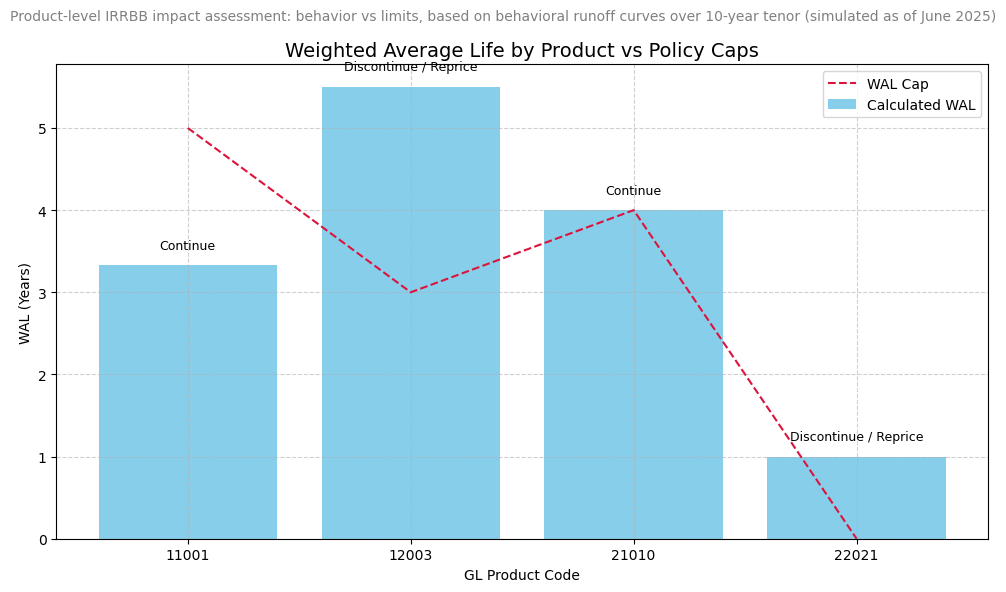

In [43]:
plt.figure(figsize=(10,6))
bars = plt.bar(wal_df['GL_Code'], wal_df['WAL (Years)'], color='skyblue', label='Calculated WAL')
plt.plot(wal_df['GL_Code'], wal_df['Policy Cap'], color='crimson', linestyle='--', label='WAL Cap')

# Annotate bars
for bar, decision in zip(bars, wal_df['Decision']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, decision, ha='center', fontsize=9)

plt.title("Weighted Average Life by Product vs Policy Caps", fontsize = 14)
plt.suptitle("Product-level IRRBB impact assessment: behavior vs limits, based on behavioral runoff curves over 10-year tenor (simulated as of June 2025)", fontsize=10, color='gray')
plt.ylabel("WAL (Years)")
plt.xlabel("GL Product Code")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f'WAL_vs_PolicyCap_{timestamp}.png', dpi=300)
plt.show()